# Notebook 1: Enhancing Images with ControlNet and Stable Diffusion

### 1. Install Required Libraries

In [1]:
# Run this cell to install necessary packages
!pip install --upgrade diffusers transformers torch torchvision ipywidgets
!pip install opencv-python matplotlib timm

#### 3.1 Optional: Install `accelerate` for faster and less memory-intense model loading.

In [2]:
!pip install accelerate

### 2. Import Libraries

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 3. Load Models

In [4]:
# Use a seed for reproducibility
SEED = 0

In [5]:
# Load the ControlNet model (Canny edge detection)
controlnet_canny = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

In [6]:
# Load the Stable Diffusion pipeline with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet_canny,
    torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/jeremy/Documents/diffusion-playground/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Enable GPU acceleration
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device)

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [8]:
# Use an efficient scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 4. Prepare Input Image and Control Image

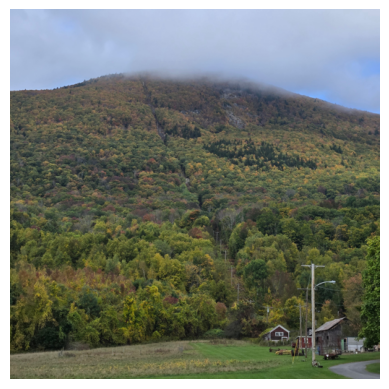

In [9]:
# Load the input image
input_image = Image.open("test-images/20240929_102048-EDIT.jpg").convert("RGB")
input_image = input_image.resize((512, 512))

plt.imshow(input_image)
plt.axis('off')  # Hide the axes
plt.show()

In [10]:
# Convert the image to a NumPy array
image_np = np.array(input_image)

In [11]:
# Apply Canny edge detection
low_threshold = 150
high_threshold = 200
edges = cv2.Canny(image_np, low_threshold, high_threshold)

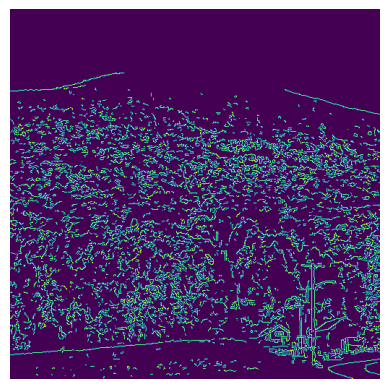

In [12]:
# Convert edges to PIL Image
control_image_canny = Image.fromarray(edges)

plt.imshow(control_image_canny)
plt.axis('off')  # Hide the axes
plt.show()

### 5. Define Parameters

In [13]:
# Set the number of sampling steps
num_inference_steps = 50

# Define prompts and parameters
prompt = "a landscape with trees and a mountain"
negative_prompt = "low quality, blurry, deformed, bad anatomy"
guidance_scale = 7.5

### 6. Generate the Enhanced Image

In [14]:
# Generate the enhanced image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        control_image=control_image_canny,
        generator=torch.Generator(device="cpu").manual_seed(SEED),
    )

enhanced_image = output.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

### 7. Display and Save the Results

In [15]:
# Save the enhanced image
enhanced_image.save("output-images/enhanced_controlnet-canny.jpg")

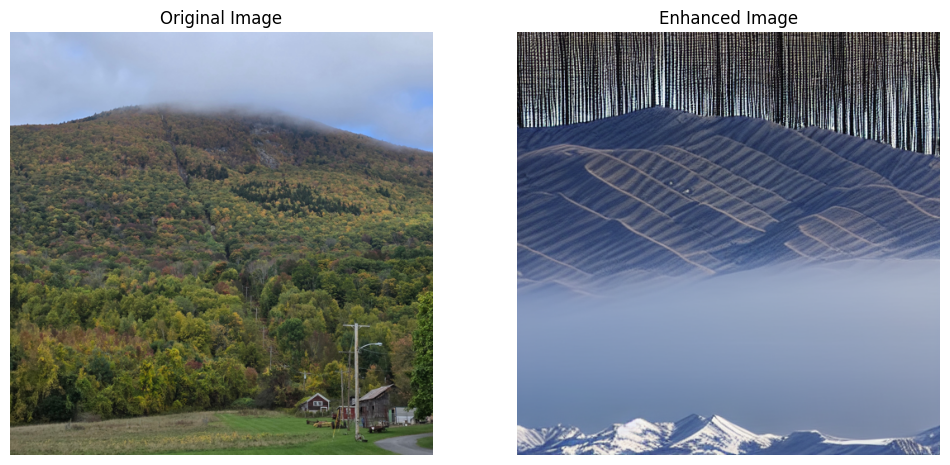

In [16]:
# Display the original and enhanced images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(enhanced_image)
ax[1].set_title("Enhanced Image")
ax[1].axis("off")

plt.show()

## 8. Using the ControlNet Depth Model

In [17]:
# Load the ControlNet depth model
controlnet_depth = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float16
)

In [18]:
# Load the Stable Diffusion pipeline with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet_depth,
    torch_dtype=torch.float16
)

# Enable GPU acceleration
pipe.to("cuda")

# Use an efficient scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
### 9. Generate the Depth Map using MiDaS

In [20]:
def generate_depth_map(input_image):
    """
    Generate a depth map from the input image using the MiDaS model.
    :param input_image: PIL Image (RGB)
    :return: depth_map as a NumPy array
    """
    # Load the MiDaS model from PyTorch Hub
    model = torch.hub.load("intel-isl/MiDaS", "MiDaS").to(device)
    model.eval()

    # Load transforms required by MiDaS
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.default_transform

    # Convert the input image to a format suitable for MiDaS
    img = np.array(input_image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = transform(img).to("cuda")

    # Predict depth
    with torch.no_grad():
        prediction = model(img)

        # Resize depth map to match input image dimensions
        depth_map = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=input_image.size[::-1],
            mode="bicubic",
            align_corners=False
        ).squeeze()

    # Convert to NumPy and normalize
    depth_map = depth_map.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())  # Normalize to 0-1
    depth_map = (depth_map * 255).astype(np.uint8)

    return depth_map

In [21]:
control_image_depth = generate_depth_map(input_image)

Using cache found in /home/jeremy/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/jeremy/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/jeremy/.cache/torch/hub/intel-isl_MiDaS_master


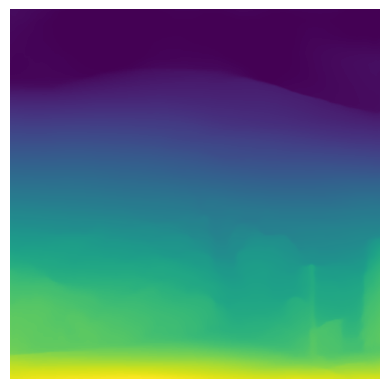

In [22]:
# # Convert edges to PIL Image
# control_image = Image.fromarray(edges)

plt.imshow(control_image_depth)
plt.axis('off')  # Hide the axes
plt.show()

In [23]:
### 10. Generate the Enhanced Image with Depth Map

In [24]:
# Generate the enhanced image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        control_image=control_image_depth,
        generator=torch.Generator(device="cpu").manual_seed(SEED),
    )

enhanced_image = output.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

### 11. Display and Save the Results

In [25]:
# Save the enhanced image
enhanced_image.save("output-images/enhanced_controlnet-depth.jpg")

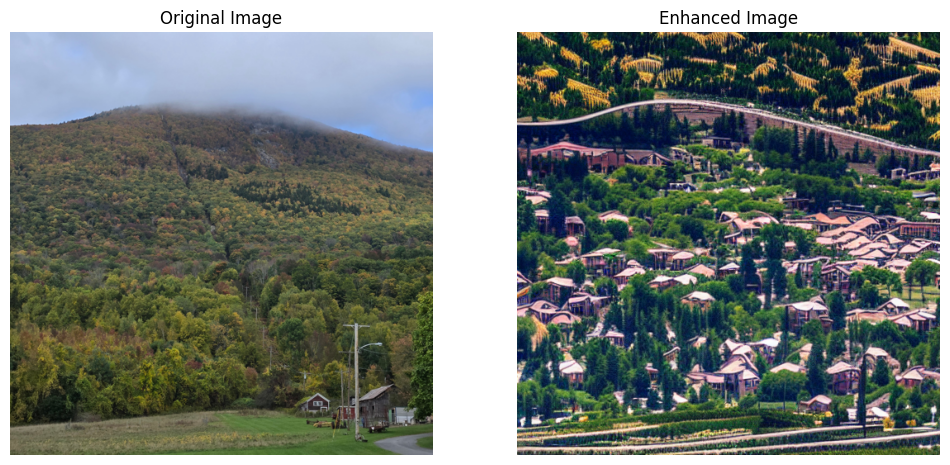

In [26]:
# Display the original and enhanced images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(enhanced_image)
ax[1].set_title("Enhanced Image")
ax[1].axis("off")

plt.show()

In [27]:
## 12. Using both ControlNet Canny and Depth Models

In [28]:
# Load the Stable Diffusion pipeline with ControlNet (using both controlnets)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=[controlnet_canny, controlnet_depth],  # Using multiple ControlNets
    safety_checker=None,
    torch_dtype=torch.float16
)

# Enable GPU acceleration
pipe.to("cuda")

# Use an efficient scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### 13. Generate the Enhanced Image with Both ControlNet Models

In [29]:
# Define a prompt to guide the generation
prompt = "a realistic landscape of a foggy mountain with autumn trees, vibrant colors, and a farmhouse at the base"
negative_prompt = "low quality, blurry, deformed, bad anatomy"
num_inference_steps = 50
guidance_scale = 7.5
controlnet_conditioning_scale = [0.8, 0.7]

In [30]:
# Pass both control images (Canny edges and Depth Map) as inputs to the pipeline
with torch.autocast("cuda"), torch.no_grad():
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=[input_image, input_image],
        control_image=[control_image_canny, control_image_depth],  # Multiple control images
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=torch.Generator(device="cpu").manual_seed(SEED),
    )

enhanced_image = output.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

### 14. Display and Save the Results

In [31]:
# Save the enhanced image
enhanced_image.save("output-images/enhanced_controlnet-multi.jpg")

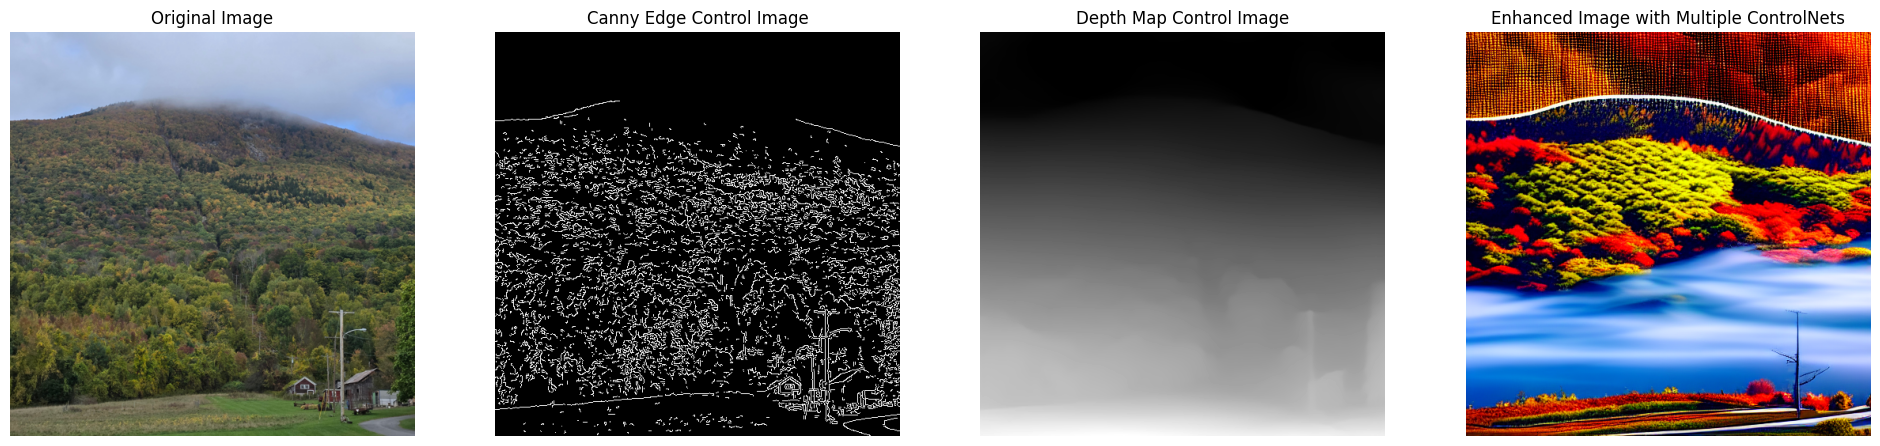

In [32]:
# Display the original, control images, and enhanced image
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(control_image_canny, cmap='gray')
ax[1].set_title("Canny Edge Control Image")
ax[1].axis("off")

ax[2].imshow(control_image_depth, cmap='gray')
ax[2].set_title("Depth Map Control Image")
ax[2].axis("off")

ax[3].imshow(enhanced_image)
ax[3].set_title("Enhanced Image with Multiple ControlNets")
ax[3].axis("off")

plt.show()